In [2]:
# !pip install wordcloud
# !pip install pandarallel
# !pip install contractions
# !pip install --upgrade pip
# !pip install --upgrade azure-cognitiveservices-language-textanalytics

In [1]:
import json
import math
import nltk
import keys
import requests
import numpy as np
import contractions
import pandas as pd
    
from datetime import datetime
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from pandarallel import pandarallel
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.language.textanalytics import TextAnalyticsClient

#from keys import subscription_key, text_analytics_base_url, bing_spell_check_key, spell_check_url 

In [2]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
raw_tweets = pd.read_csv(
    "sample_tweets.csv",
    index_col=None
)

In [4]:
raw_tweets["id"] = raw_tweets.index
raw_tweets.rename(columns={"Body text": "text"}, inplace=True)
raw_tweets.head(2)

,Down ID,Posted time,text,Point latitiude,Point longitude,Bio location,Image url,id
0,"""tag:search.twitter.com,2005:1109081183105835008""",22/03/2019 13:15,"""Primeape was recently spotted trying to make ...",NaN,NaN,NaN,"""https://pbs.twimg.com/profile_images/76017773...",0
1,"""tag:search.twitter.com,2005:1109080961277407234""",22/03/2019 13:14,"""@gianninewbon Meet me at London Bridge at hal...",NaN,NaN,"""Derbados""","""https://pbs.twimg.com/profile_images/10569615...",1


In [5]:
raw_tweets.count()

Down ID            44816
Posted time        44816
text               44816
Point latitiude      701
Point longitude      701
Bio location       31946
Image url          42978
id                 44816
dtype: int64

In [6]:
# ~51% duplicates
raw_tweets.drop_duplicates(subset=['text']).count()

Down ID            22022
Posted time        22022
text               22022
Point latitiude      678
Point longitude      678
Bio location       15688
Image url          20558
id                 22022
dtype: int64

In [7]:
tweets = raw_tweets.groupby(["text"]).id.count().reset_index()
tweets.columns = ["text", "count"]
tweets.sort_values(by="count", inplace=True, ascending=False)
tweets.head()

,text,count
11637,"""LOL I JUST HEARD THE TUBE COORDINATOR (or wha...",2470
15277,"""RT @EtniesJags: “London Bridge is falling dow...",1955
9621,"""For anyone believing that corruption is mainl...",654
20342,"""You mean like the 7/7 tube bombers did, the M...",608
15915,"""RT @kurtnysgvia: Tangina yung grades ko paran...",593


In [8]:
tweets["text"].replace(r'^\s*$', np.nan, regex=True).isna().sum()

0

In [9]:
def spell_check(sentence):
    data = {'text': sentence}
    params = {
        'mkt':'en-us',
        'mode':'proof'
        }
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Ocp-Apim-Subscription-Key': bing_spell_check_key,
        }
    response = requests.post(spell_check_url, headers=headers, params=params, data=data)
    json_response = response.json()

    for token in json_response["flaggedTokens"]:
        sentence = sentence.replace(str(token["token"]), token["suggestions"][0]["suggestion"])
    
    return sentence

In [10]:
tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
def process_tweet(tweet):
    normalized_tweet = tweet.lower().strip()
    normalized_tweet = normalized_tweet.replace("“","")
    try:
        normalized_tweet = spell_check(str(normalized_tweet))        
        normalized_tweet = contractions.fix(normalized_tweet)
        tokenized = tokenizer.tokenize(normalized_tweet)
    except:
        tokenized = normalized_tweet.split(" ")
        
    isascii = lambda s: len(s) == len(s.encode())  
    ascii_words = []
    for word in tokenized:
        if isascii(word):
            if ("http" not in word):
                ascii_words.append(word)
    
    normalized_tweet = " ".join(ascii_words)
    normalized_tweet = normalized_tweet.lower().strip()
    normalized_tweet = normalized_tweet.replace("-","")
    normalized_tweet = normalized_tweet.replace("'","")
    normalized_tweet = normalized_tweet.replace('"', '')
    normalized_tweet = normalized_tweet.replace("  "," ")
    normalized_tweet = normalized_tweet.strip()
    
    return normalized_tweet


In [11]:
process_tweet("London Bridge - London Bridge.")

'london bridge london bridge.'

In [12]:
pandarallel.initialize(nb_workers=32)
print("Process started at {}".format(datetime.now()))
tweets["processed_text"] = tweets["text"].parallel_apply(process_tweet)
print("Process ended at {}".format(datetime.now()))

New pandarallel memory created - Size: 2000 MB
Pandarallel will run on 32 workers
Process started at 2019-07-11 22:43:46.392618
Process ended at 2019-07-11 22:43:46.886115


### Key Phrases

In [13]:
tweets.reset_index(inplace=True)
tweets.head()

,index,text,count,processed_text
0,11637,"""LOL I JUST HEARD THE TUBE COORDINATOR (or wha...",2470,lol i just heard the tube coordinator (or what...
1,15277,"""RT @EtniesJags: “London Bridge is falling dow...",1955,"rt @etniesjags: london bridge is falling down,..."
2,9621,"""For anyone believing that corruption is mainl...",654,for anyone believing that corruption is mainly...
3,20342,"""You mean like the 7/7 tube bombers did, the M...",608,"you mean like the 7/7 tube bombers did, the ma..."
4,15915,"""RT @kurtnysgvia: Tangina yung grades ko paran...",593,rt @kurtnysgvia: tangina yung grades ko parang...


In [15]:
tweet_list = tweets[["index", "processed_text"]].rename(
        columns={"index":"id", "processed_text": "text"}
    ).to_json(orient = "records")

json.loads(tweet_list)[0:5]

[{'id': 11637,
  'text': 'lol i just heard the tube coordinator (or whatever they are called) at london bridge just say into his all my guys are bolaz, please stand clear of the'},
 {'id': 15277,
  'text': 'rt @etniesjags: london bridge is falling down, my dear'},
 {'id': 9621,
  'text': 'for anyone believing that corruption is mainly third world this article detailing how of public money was spent on a non existent london bridge is a must read. at the centre of the scandal: @borisjohnson, the man planning to be next uk pm'},
 {'id': 20342,
  'text': 'you mean like the 7/7 tube bombers did, the marchester arena bomber did and the london bridge and westminster killers did ... demonising anyone who didnt follow islam?? you are a hypocrite of mammoth propertions the flames of hatred are fanned, when people are demonised because of their faith, when we play on peoples fears rather than addressing them, the consequences are deadly, as we have seen so sadly today.'},
 {'id': 15915,
  'text':

In [17]:
headers = {"Ocp-Apim-Subscription-Key": subscription_key}
keyphrase_url = text_analytics_base_url + "keyPhrases"

key_phrases_df = pd.DataFrame()
tweets_chunks = np.array_split(json.loads(tweet_list), 
                               math.ceil(len(tweets)/1000))

for chunk in tweets_chunks:
    chunk_json = json.loads(json.dumps({"documents" : list(chunk)})) 
    response  = requests.post(keyphrase_url, 
                              headers=headers, 
                              json=chunk_json)
    key_phrases = response.json()
    key_phrases_df = key_phrases_df.append(
        pd.DataFrame.from_dict(
            key_phrases['documents']
        )
    )

In [18]:
key_phrases_df.head()

,id,keyPhrases
0,11637,"[guys, tube coordinator, bolaz, london bridge]"
1,15277,"[london bridge, rt, etniesjags]"
2,9621,"[man, article, scandal, borisjohnson, world, p..."
3,20342,"[london bridge, marchester arena bomber, flame..."
4,15915,[tangina yung grades ko parang london bridge n...


In [19]:
key_phrases_df.count()

id            22018
keyPhrases    22018
dtype: int64

In [43]:
def get_short_key_phrases(keyPhrases):
    shorter_phrases = []
    for phrase in keyPhrases:
        if len(phrase.split(" ")) <  5:
            shorter_phrases.append(phrase)
    return shorter_phrases
key_phrases_df["shortKeyPhrases"] = key_phrases_df["keyPhrases"].apply(get_short_key_phrases)

In [21]:
key_phrases_df.head()

,id,keyPhrases,shortKeyPhrases
0,11637,"[guys, tube coordinator, bolaz, london bridge]","[guys, tube coordinator, bolaz, london bridge]"
1,15277,"[london bridge, rt, etniesjags]","[london bridge, rt, etniesjags]"
2,9621,"[man, article, scandal, borisjohnson, world, p...","[man, article, scandal, borisjohnson, world, p..."
3,20342,"[london bridge, marchester arena bomber, flame...","[london bridge, marchester arena bomber, flame..."
4,15915,[tangina yung grades ko parang london bridge n...,[kurtnysgvia]


In [22]:
tweets.head()

,index,text,count,processed_text
0,11637,"""LOL I JUST HEARD THE TUBE COORDINATOR (or wha...",2470,lol i just heard the tube coordinator (or what...
1,15277,"""RT @EtniesJags: “London Bridge is falling dow...",1955,"rt @etniesjags: london bridge is falling down,..."
2,9621,"""For anyone believing that corruption is mainl...",654,for anyone believing that corruption is mainly...
3,20342,"""You mean like the 7/7 tube bombers did, the M...",608,"you mean like the 7/7 tube bombers did, the ma..."
4,15915,"""RT @kurtnysgvia: Tangina yung grades ko paran...",593,rt @kurtnysgvia: tangina yung grades ko parang...


In [23]:
(
  key_phrases_df["keyPhrases"].apply(lambda x: len(x)).mean(),
  key_phrases_df["keyPhrases"].apply(lambda x: len(x)).max(),
  key_phrases_df["keyPhrases"].apply(lambda x: len(x)).min()
)

(5.812017440276137, 81, 0)

In [24]:
(
  key_phrases_df["shortKeyPhrases"].apply(lambda x: len(x)).mean(),
  key_phrases_df["shortKeyPhrases"].apply(lambda x: len(x)).max(),
  key_phrases_df["shortKeyPhrases"].apply(lambda x: len(x)).min()
)

(5.654146607321283, 81, 0)

In [273]:
key_phrases_df[key_phrases_df["shortKeyPhrases"].map(len)>10].count()

id                 1383
keyPhrases         1383
shortKeyPhrases    1383
dtype: int64

In [27]:
not_covered_list = []
def no_key_phrases(row):
    if len(row.keyPhrases) == 0:
        not_covered_list.append(row.id)
        return 1
not_covered =  key_phrases_df.apply(no_key_phrases, axis=1).sum()

print("Number of posts not covered by Key Phrases: {} or {} %".format(
    not_covered, 
    (not_covered/len(key_phrases_df)*100)
    )
)

Number of posts not covered by Key Phrases: 1.0 or 0.004541738577527478 %


In [28]:
not_covered_list = []
def no_key_phrases(row):
    if len(row.shortKeyPhrases) == 0:
        not_covered_list.append(row.id)
        return 1
not_covered =  key_phrases_df.apply(no_key_phrases, axis=1).sum()

print("Number of posts not covered by Shortened Key Phrases: {} or {} %".format(
    not_covered, 
    (not_covered/len(key_phrases_df)*100)
    )
)

Number of posts not covered by Shortened Key Phrases: 290.0 or 1.3171041874829683 %


In [35]:
for text in tweets[tweets["index"].isin(not_covered_list)].text.values[0:5]:
    print(">>>>>>>>>>>>>")
    print(text)
    # print(process_tweet(text))

>>>>>>>>>>>>>
"Londra Tamigi Tower Bridge città che trae origini romane Albione https://t.co/WFXSTVKYci
https://www.immaginienonsoloparole.it/londra-tamigi-tower-bridge-11-prospettive-inconsuete-2016-01-08"
>>>>>>>>>>>>>
"#ラジオ深夜便 思い出のスクリーン・ミュージック 私の好きなラヴ・ストーリー作品集 https://t.co/qeSwa7G9si Waterloo Bridge (マイラ・レスター)Vivien Leigh Robert Taylor https://t.co/ti9RfBufMf 君の名は ♪織井茂子 https://t.co/1khSrgeQbE Auld Lang Syne https://t.co/sxEH1ZhwrM
https://www.youtube.com/watch?v=NEn0NjGI4Fs&feature=youtu.be
https://www.youtube.com/watch?v=6egm4SNGLbY&feature=youtu.be
https://www.youtube.com/watch?v=4HGcUPkCtyQ&feature=youtu.be"
>>>>>>>>>>>>>
"The Memorial Art Gallery highlights Monet's ""Waterloo Bridge"" series https://t.co/r6bZn8AExk
https://www.wxxinews.org/post/memorial-art-gallery-highlights-monets-waterloo-bridge-series"
>>>>>>>>>>>>>
"Keşke bu kadar iddialı şeyler söylemesek. En son Gökçek, Güvenpark'a ""Tower Bridge'ın aynısını yapacağız"" dediğinde Londra belediye başkanı, Gökçek'in meclis

In [36]:
def key_phrases_category_count():
    unique_key_phrases = set(sum(key_phrases_df["shortKeyPhrases"], []))

    key_phrases_category = {}
    for key in unique_key_phrases:
        key_phrases_category[key] = []

    def map_categories(row):
        for phrase in row["shortKeyPhrases"]:
            key_phrases_category[phrase].append(row["id"])
        return None

    key_phrases_df.apply(map_categories, axis=1)

    key_phrases_category_count={}
    for key, value in key_phrases_category.items():
        key_phrases_category_count[key] = len(value)

    from collections import OrderedDict
    key_phrases_category_count = OrderedDict(
                                   sorted(key_phrases_category_count.items(), 
                                          key=lambda kv: kv[1], 
                                          reverse=True)
                                )
    return key_phrases_category_count


In [44]:
key_phrases_category_count_1 = key_phrases_category_count()
print(len(key_phrases_category_count_1))

top_10_keyPhrases = list(key_phrases_category_count_1)[:10]
print(top_10_keyPhrases)

42717
['london bridge', 'tower bridge', 'london', 'rt', 'railway', 'se', 'waterloo bridge', 'train', 'time', 'people']


In [51]:
def process_keyPhrases(key_phrases):
    modified_key_phrases = []
    for key_phrase in key_phrases:
        modified = False
        if len(key_phrase) < 3:
            continue
        if key_phrase in top_10_keyPhrases:
            if len(key_phrase) >= 3:
                modified_key_phrases.append(key_phrase)
        else:
            for phrase in top_10_keyPhrases:
                if len(phrase) >= 3:
                    if phrase in key_phrase:
                        already_seen = phrase
                        rest = key_phrase.split(already_seen)[1].strip()
                        if len(rest) >= 3:
                            modified_key_phrases+=[already_seen, rest]
                        else:
                            modified_key_phrases+=[already_seen]
                        modified = True
                        break
                    if phrase.replace(" ", "") == key_phrase:
                        modified_key_phrases.append(phrase)
                        modified = True
                        break                        
            if not modified:
                if len(phrase) >= 3:
                    modified_key_phrases.append(key_phrase) 
    return [x for x in modified_key_phrases if x]


In [49]:
key_phrases_df.head()

,id,keyPhrases,shortKeyPhrases
0,11637,"[guys, tube coordinator, bolaz, london bridge]","[guys, tube coordinator, bolaz, london bridge]"
1,15277,"[london bridge, rt, etniesjags]","[london bridge, rt, etniesjags]"
2,9621,"[man, article, scandal, borisjohnson, world, p...","[man, article, scandal, borisjohnson, world, p..."
3,20342,"[london bridge, marchester arena bomber, flame...","[london bridge, marchester arena bomber, flame..."
4,15915,[tangina yung grades ko parang london bridge n...,[kurtnysgvia]


In [52]:
key_phrases_df["shortKeyPhrases"] = key_phrases_df["shortKeyPhrases"].apply(process_keyPhrases)

In [53]:
key_phrases_category_count_2 = key_phrases_category_count()
print(len(key_phrases_category_count_2))

top_10_keyPhrases = list(key_phrases_category_count_2)[:10]
print(top_10_keyPhrases)

39051
['london bridge', 'tower bridge', 'london', 'train', 'time', 'railway', 'people', 'waterloo bridge', 'station', 'attack']


In [244]:
key_phrases_count_dict = pd.DataFrame(list(zip(
        key_phrases_category_count_2.keys(),
        key_phrases_category_count_2.values())),
        columns=["keyPhrase", "count"])

In [245]:
key_phrases_count_dict.head()

,keyPhrase,count
0,london bridge,14138
1,tower bridge,3924
2,london,3731
3,train,1433
4,time,999


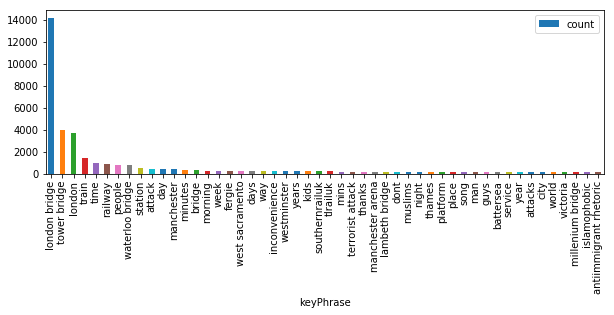

In [265]:
key_phrases_count_dict.iloc[:50,:].plot(
    x="keyPhrase", 
    y="count", 
    kind="bar",
    figsize=(10,3)
)

In [ ]:
key_phrases_count_dict.iloc[:5000,:].plot(
    y="count", 
    kind="bar",
    figsize=(10,3)
)

In [54]:
key_phrases_category_count_2

OrderedDict([('london bridge', 14138),
             ('tower bridge', 3924),
             ('london', 3731),
             ('train', 1433),
             ('time', 999),
             ('railway', 875),
             ('people', 768),
             ('waterloo bridge', 752),
             ('station', 502),
             ('attack', 404),
             ('day', 383),
             ('manchester', 371),
             ('minutes', 328),
             ('bridge', 281),
             ('morning', 264),
             ('week', 259),
             ('fergie', 253),
             ('west sacramento', 244),
             ('days', 242),
             ('way', 239),
             ('inconvenience', 213),
             ('westminster', 210),
             ('years', 207),
             ('kids', 204),
             ('southernrailuk', 203),
             ('tlrailuk', 200),
             ('mins', 182),
             ('terrorist attack', 176),
             ('thanks', 174),
             ('manchester arena', 173),
             ('lambeth bridge', 

In [59]:
tweet_keyPhrases["keyPhrases"].head()

0       [guys, tube coordinator, bolaz, london bridge]
1                      [london bridge, rt, etniesjags]
2    [man, article, scandal, borisjohnson, world, p...
3    [london bridge, marchester arena bomber, flame...
4    [tangina yung grades ko parang london bridge n...
Name: keyPhrases, dtype: object

In [171]:
def exists_in_top_x(top_x, keyPhrases, count):
    if not isinstance(keyPhrases, float):
        for item in top_x:
            if item in keyPhrases:
                return count
    return 0

In [190]:
top_100_key_phrases = list(key_phrases_category_count_2.keys())[0:100]
tweet_keyPhrases['covered_top_100'] = tweet_keyPhrases[["keyPhrases", "count"]].apply(
    lambda x: exists_in_top_x(top_100_key_phrases, x["keyPhrases"], x["count"]),
    axis=1
)
tweet_keyPhrases['covered_top_100'].sum()/(tweet_keyPhrases["count"].sum())*100

74.42654409139593

In [191]:
top_1000_key_phrases = list(key_phrases_category_count_2.keys())[0:1000]
tweet_keyPhrases['covered_top_1000'] = tweet_keyPhrases[["keyPhrases", "count"]].apply(
    lambda x: exists_in_top_x(top_1000_key_phrases, x["keyPhrases"], x["count"]),
    axis=1
)
tweet_keyPhrases['covered_top_1000'].sum()/(tweet_keyPhrases["count"].sum())*100

87.25678329168154

In [195]:
top_2600_key_phrases = list(key_phrases_category_count_2.keys())[0:2600]
tweet_keyPhrases['covered_top_2600'] = tweet_keyPhrases[["keyPhrases", "count"]].apply(
    lambda x: exists_in_top_x(top_2600_key_phrases, x["keyPhrases"], x["count"]),
    axis=1
)
tweet_keyPhrases['covered_top_2600'].sum()/(tweet_keyPhrases["count"].sum())*100

90.04373438057837

In [196]:
2600/tweet_keyPhrases["count"].sum()*100

5.801499464476972

In [197]:
key_phrases_df.id = key_phrases_df.id.astype(int)
tweet_keyPhrases = pd.merge(
    tweets[["index", "text", "processed_text", "count"]], 
    key_phrases_df[["id", "keyPhrases", "shortKeyPhrases"]], 
    left_on="index", 
    right_on="id",
    how="left")

tweet_keyPhrases.sort_values(by=["count"], ascending=[False], inplace=True)
tweet_keyPhrases.to_csv("tweet_keyPhrases.csv")
tweet_keyPhrases.head()

,index,text,processed_text,count,id,keyPhrases,shortKeyPhrases
0,11637,"""LOL I JUST HEARD THE TUBE COORDINATOR (or wha...",lol i just heard the tube coordinator (or what...,2470,11637.0,"[guys, tube coordinator, bolaz, london bridge]","[guys, tube coordinator, bolaz, london bridge]"
1,15277,"""RT @EtniesJags: “London Bridge is falling dow...","rt @etniesjags: london bridge is falling down,...",1955,15277.0,"[london bridge, rt, etniesjags]","[london bridge, etniesjags]"
2,9621,"""For anyone believing that corruption is mainl...",for anyone believing that corruption is mainly...,654,9621.0,"[man, article, scandal, borisjohnson, world, p...","[man, article, scandal, borisjohnson, world, p..."
3,20342,"""You mean like the 7/7 tube bombers did, the M...","you mean like the 7/7 tube bombers did, the ma...",608,20342.0,"[london bridge, marchester arena bomber, flame...","[london bridge, marchester arena bomber, flame..."
4,15915,"""RT @kurtnysgvia: Tangina yung grades ko paran...",rt @kurtnysgvia: tangina yung grades ko parang...,593,15915.0,[tangina yung grades ko parang london bridge n...,[kurtnysgvia]


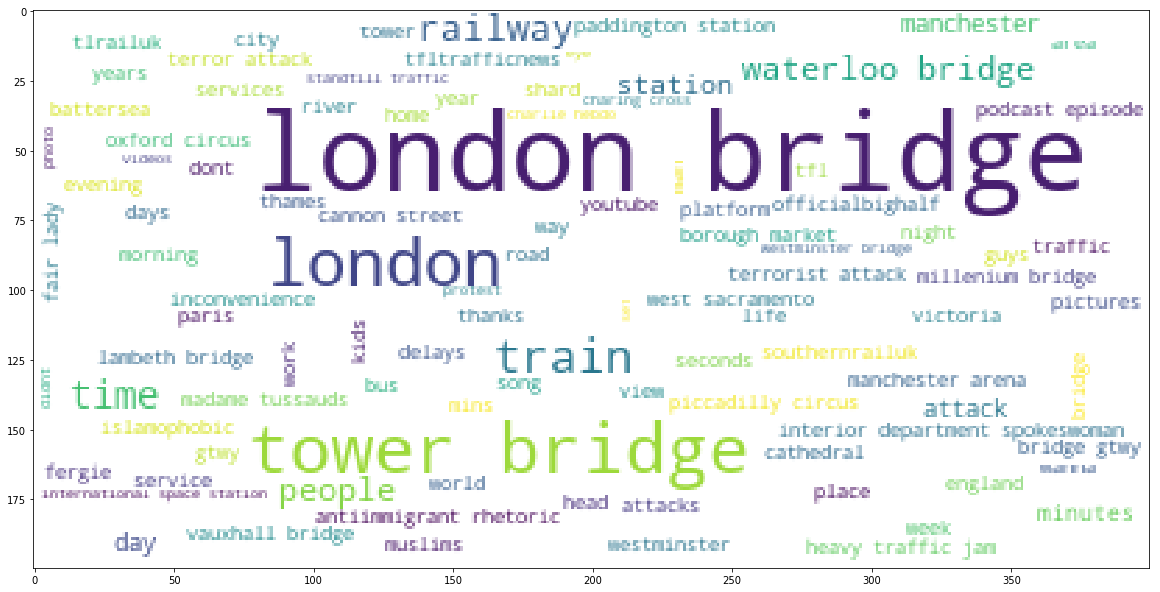

In [141]:
import matplotlib.pyplot as plt

wc = WordCloud(background_color="white",
               max_words=100,
               relative_scaling=0.5,
               normalize_plurals=False).generate_from_frequencies(key_phrases_category_count_2)
plt.figure(figsize=(20,20))
plt.imshow(wc)

__________________________________________________________________________________________________________________